Gpu

In [ ]:
!nvidia-smi

Fri Apr  2 11:46:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Importation du cvs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pe
from wordcloud import WordCloud, STOPWORDS 

from sklearn import model_selection

import torch

from torch.utils.data import DataLoader,Dataset
import warnings
from pylab import rcParams

In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/commentaires_toxiques.csv')

data.sample(5)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
7696,147a6bed31b3d7bc,"""\n\nThese pages contain material which is ha ...",0,0,0,0,0,0
109009,46dd6c0f2cdca00c,"""\n\n Robots everywhere! \n\nI see you have me...",0,0,0,0,0,0
149981,64c8d43bd74b4698,"Gwen, again, the discussion here is the manner...",0,0,0,0,0,0
58871,9daa484bc22e472f,"OK, getting started on this, I think I'll have...",0,0,0,0,0,0
120421,841b66a5a022a364,"ok so its the currupt admin: desucka,crooked b...",1,0,0,0,0,0


On peut voir que les données doivent être nettoyées

In [ ]:
df = data['comment_text']
df.iloc[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
df.iloc[58]

"My Band Page's deletion. You thought I was gone. \n\nDeleting the comment I posted on your 'talk page' does not delete my feelings for your hasty decision to delete my page. You, sir, are still a cock-sucking douche fuck. Sit back for a second and think about what your life has become. ............ Done? That didn't take long did it? Nope. Because, as I am most certainly aware, your life is a shitstorm of sitting in front of the computer masturbating to fictional creatures. Your attempts to get rid of me are mediocre at best. You are constantly sucking the dick of failure. You don't want a personal attack, huh? Well, too bad, Fuckcock McDickerson. You've got one. From me. You can go ahead and delete my profile from wikipedia. I'll just make another one and come right back to 'Syrthiss's talk page and insult the dick off of you. How could you shatter the dreams of an innocent eighteen year old college freshman trying to make a name for his band. Does that make you happy? Fucking with p

Nettoyage des données

In [ ]:
import re

def clean_comments(comment):
   #On mets tout en minuscule car plus simple pour remplacer
   comment = comment.lower()
   #remplacer les contractions
   comment = re.sub(r"n't", " not ", comment)
   comment = re.sub(r"\'ve", " have ", comment)
   comment = re.sub(r"i'm", "i am ", comment)
   comment = re.sub(r"he's got", "he has ", comment)
   comment = re.sub(r"he's", "he is ", comment)
   comment = re.sub(r"it's been", "it has been ", comment)
   comment = re.sub(r"it's", "it is ", comment)
   comment = re.sub(r"\'re", " are ", comment)
   comment = re.sub(r"\'d", " would ", comment)
   comment = re.sub(r"\'ll", " will ", comment)
   #équivalent classe [^a-zA-Z0-9]
   comment = re.sub('\W', ' ', comment)
   #éliminer les espaces inutiles
   comment = re.sub(r'\s+', ' ', comment) 
   return comment

In [ ]:
data['comment_text'] = df.map(lambda comment : clean_comments(comment))
data['comment_text'].iloc[0]

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

Données test et train

In [ ]:
from sklearn.model_selection import train_test_split

categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train, test = train_test_split(data, test_size=0.20, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(127656,)
(31915,)


In [ ]:
X_train.head()

144418    however tlc is the one that listed it by the w...
84044     next rfa s jahiegel if he ever agrees to run a...
36021      ok i agree with you thank you i will discuss it 
141771    also if you can think of a nickname to be call...
6037       guess why i do not bother to take a nickname ...
Name: comment_text, dtype: object

On sauvegarde X_train et train pour l'application

In [ ]:
X_train.to_pickle('X_train.pkl')

In [ ]:
train.to_pickle('train.pkl')

In [ ]:
type(X_train)

pandas.core.series.Series

Analyse des données

Répartition des données selon les catégories

In [ ]:
categories = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [ ]:
lab_c = pd.DataFrame(train[categories].sum()).reset_index()
lab_c.columns = ['Type','Count']
fig = pe.bar(lab_c, x='Type', y='Count')
fig.show()

Wordcloud des mots dont les phrases sont répertoriées dans au moins 3 catégories

In [ ]:
sample = train.head(100)[train.head(5000).sum(axis=1)>=3]
sample

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
20293,359b3dc8ad6d926d,homo do not be gay mind your own fucking busin...,1,0,1,0,1,1
37507,642ef6eb83bb5722,fuck 62 158 73 165 62 158 73 165 62 158 73 165...,1,1,1,0,1,0
17492,2e34dcd040fe16c4,is iridescant is a faggot,1,0,1,0,1,1
5431,0e7bf095144c3b75,and suck a dick two times every hour until sun...,1,0,1,0,1,0
123930,96d895add7fb5711,vandalising the page how did i vandalise the p...,1,1,1,0,1,0


In [ ]:
def wordcloud(df):
    comment_words = ''   
    stopwords = set(STOPWORDS) 
    # on parcours les commentaires
    for val in df.comment_text: 
        # on s'assure que ce soit des strings
        val = str(val) 
        # on split les commentaires 
        tokens = val.split() 
        # on convertit nos tokens en minuscule
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        comment_words += " ".join(tokens)+" "

    # on construit notre nuage de mots
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',  
                stopwords=stopwords,
                min_font_size = 10).generate(comment_words) 


    # on plot l'image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

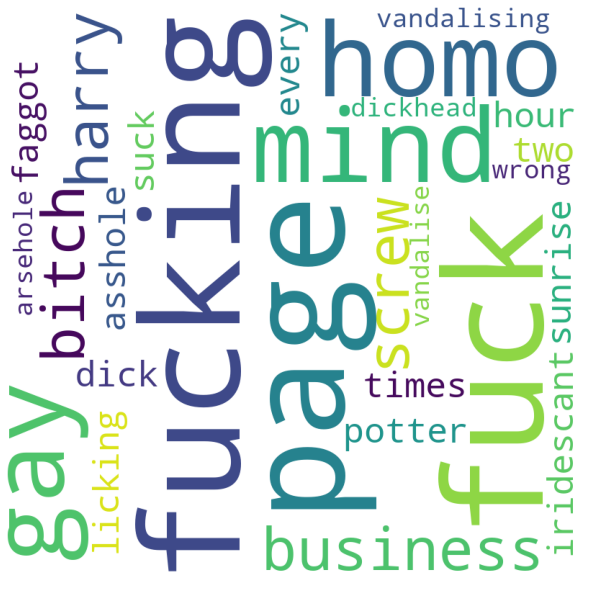

In [ ]:
wordcloud(sample)

Entrainement avec Régression Logistique

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

model = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # entrainement en fonction du commentaire et de la catégorie étudiée
    model.fit(X_train, train[category])
    # on prédit avec X_test
    prediction = model.predict(X_test)
    confusion=confusion_matrix(test[category],prediction)
    print(confusion)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
... Processing toxic
[[28692   162]
 [ 1255  1806]]
Test accuracy is 0.9556008146639511
... Processing severe_toxic
[[31531    57]
 [  246    81]]
Test accuracy is 0.9905060316465611
... Processing obscene
[[30141   107]
 [  610  1057]]
Test accuracy is 0.9775340748864171
... Processing threat
[[31821     6]
 [   80     8]]
Test accuracy is 0.9973053423155256
... Processing insult
[[30182   160]
 [  777   796]]
Test accuracy is 0.9706407645307848
... Processing identity_hate
[[31613    18]
 [  236    48]]
Test accuracy is 0.9920413598621338


Test pour la phrase "COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK"

In [ ]:
text_test = ["COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK"]
data_test = pd.DataFrame({'Comment':text_test})
data_test['Comment'] = data_test['Comment'].map(lambda comment : clean_comments(comment))
data_test.Comment
print (data_test.Comment)

for category in categories:
    print('... Processing {}'.format(category))
    # entrainement en fonction du commentaire et de la catégorie étudiée
    model.fit(X_train, train[category])
    # on prédit notre commentaire
    prediction = model.predict(data_test.Comment)
    print(prediction)
    proba = model.predict_proba(data_test.Comment)[:,1]
    print(proba)

0    cocksucker before you piss around on my work
Name: Comment, dtype: object
... Processing toxic
[1]
[0.89198305]
... Processing severe_toxic
[0]
[0.08747532]
... Processing obscene
[1]
[0.71360788]
... Processing threat
[0]
[0.00428625]
... Processing insult
[1]
[0.5691091]
... Processing identity_hate
[0]
[0.00774667]


Test pour n'importe qu'elle phrase en entrée

In [43]:
phrase_test = input("Entrez une phrase en anglais: ")
list = []
list.append(phrase_test)
data_test = pd.DataFrame({'Comment':list})
data_test['Comment'] = data_test['Comment'].map(lambda comment : clean_comments(comment))
data_test.Comment
print (data_test.Comment)

predictions = {}

final_predictions = {}

for category in categories:
  print('... Processing {}'.format(category))
  # entrainement en fonction du commentaire et de la catégorie étudiée
  model.fit(X_train, train[category])
  # on prédit notre commentaire
  prediction = model.predict(data_test.Comment)
  proba = model.predict_proba(data_test.Comment)[:,1]
  final_predictions[category] = prediction
  predictions[category] = proba

for prediction in final_predictions:
  print(prediction)

Entrez une phrase en anglais: I hate you
0    i hate you
Name: Comment, dtype: object
... Processing toxic
... Processing severe_toxic
... Processing obscene
... Processing threat
... Processing insult
... Processing identity_hate
toxic
severe_toxic
obscene
threat
insult
identity_hate


Application Flask

In [35]:
from sklearn.externals import joblib
joblib.dump(model, 'model.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



['model.pkl']

In [36]:
!pip install flask-ngrok

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask , request, render_template
app = Flask(__name__, template_folder='drive/My Drive')
run_with_ngrok(app)   
@app.route('/')
def my_form():
    return render_template('test.html')
  
@app.route('/', methods=['POST'])
def my_form_post():
    text = request.form['text']
    list = []
    list.append(text)
    data_test = pd.DataFrame({'Comment':list})
    data_test['Comment'] = data_test['Comment'].map(lambda comment : clean_comments(comment))
    data_test.Comment

    predictions = {}

    final_predictions = {}

    categories = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

    X_train = pd.read_pickle("X_train.pkl")

    train = pd.read_pickle("train.pkl")

    for category in categories:
      print('... Processing {}'.format(category))
      # entrainement en fonction du commentaire et de la catégorie étudiée
      model.fit(X_train, train[category])
      # on prédit notre commentaire
      prediction = model.predict(data_test.Comment)
      proba = model.predict_proba(data_test.Comment)[:,1]
      final_predictions[category] = prediction
      predictions[category] = proba

     
    return render_template('test.html', text=text,
                           categories = categories,
                           final_predictions = final_predictions,
                           prediction_toxic=predictions['toxic'],
                           prediction_severe_toxic=predictions['severe_toxic'],
                           prediction_obscene=predictions['obscene'],
                           prediction_threat=predictions['threat'],
                           prediction_insult=predictions['insult'],
                           prediction_identity_hate=predictions['identity_hate'])
                   

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://4268424f9610.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [02/Apr/2021 14:33:12] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Apr/2021 14:33:12] "GET /favicon.ico HTTP/1.1" 404 -


... Processing toxic
... Processing severe_toxic
... Processing obscene
... Processing threat
... Processing insult
... Processing identity_hate


127.0.0.1 - - [02/Apr/2021 14:47:43] "POST / HTTP/1.1" 200 -


... Processing toxic
... Processing severe_toxic
... Processing obscene
... Processing threat
... Processing insult
... Processing identity_hate


127.0.0.1 - - [02/Apr/2021 14:49:10] "POST / HTTP/1.1" 200 -
